In [1]:
%load_ext watermark
%watermark -a 'cs224' -u -d -v -p numpy,xarray,scipy,pandas,sklearn,matplotlib,seaborn,pymc3

cs224 
last updated: 2020-04-01 

CPython 3.6.10
IPython 7.13.0

numpy 1.18.1
xarray 0.15.0
scipy 1.4.1
pandas 1.0.2
sklearn 0.22.1
matplotlib 3.1.3
seaborn 0.10.0
pymc3 3.8


In [2]:
%matplotlib inline
import numpy as np, scipy, scipy.stats as stats, scipy.special, scipy.misc, pandas as pd, matplotlib.pyplot as plt, seaborn as sns, xarray as xr
import matplotlib as mpl

import pymc3 as pm

import theano as thno
import theano.tensor as T

import sklearn, sklearn.linear_model

import datetime, time, math
from dateutil import relativedelta

from collections import OrderedDict

SEED = 42
np.random.seed(SEED)

pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
# pd.set_option('display.float_format', lambda x: '%.2f' % x)
np.set_printoptions(edgeitems=10)
np.set_printoptions(linewidth=1000)
np.set_printoptions(suppress=True)
np.core.arrayprint._line_width = 180

sns.set()

In [3]:
from IPython.display import display, HTML

from IPython.display import display_html
def display_side_by_side(*args):
    html_str=''
    for df in args:
        if type(df) == np.ndarray:
            df = pd.DataFrame(df)
        html_str+=df.to_html()
    html_str = html_str.replace('table','table style="display:inline"')
    # print(html_str)
    display_html(html_str,raw=True)

CSS = """
.output {
    flex-direction: row;
}
"""

def display_graphs_side_by_side(*args):
    html_str='<table><tr>'
    for g in args:
        html_str += '<td>'
        html_str += g._repr_svg_()
        html_str += '</td>'
    html_str += '</tr></table>'
    display_html(html_str,raw=True)
    

display(HTML("<style>.container { width:70% !important; }</style>"))

In [4]:
%load_ext autoreload
%autoreload 1
%aimport covid19

Data Source: https://www.n-tv.de/panorama/Zwei-von-drei-Corona-Toten-sind-Maenner-article21681751.html

In [5]:
age_cat_dtype = pd.api.types.CategoricalDtype(categories=["< 60", "60 - 69", "70 - 79", "80 - 89", "> 90"], ordered=True)
age_cat_dtype

CategoricalDtype(categories=['< 60', '60 - 69', '70 - 79', '80 - 89', '> 90'], ordered=True)

In [6]:
sex_cat_dtype = pd.api.types.CategoricalDtype(categories=["male", "female"], ordered=False)
sex_cat_dtype

CategoricalDtype(categories=['male', 'female'], ordered=False)

In [7]:
status_cat_dtype = pd.api.types.CategoricalDtype(categories=["counted", "died"], ordered=False)
status_cat_dtype

CategoricalDtype(categories=['counted', 'died'], ordered=False)

In [8]:
columns=['age', 'sex', 'status', 'count']
df = pd.DataFrame(
[
    ['< 60'   , 'male'  , 'died',  26],
    ['< 60'   , 'female', 'died',   5],
    ['60 - 69', 'male'  , 'died',  32],
    ['60 - 69', 'female', 'died',  12],
    ['70 - 79', 'male'  , 'died', 102],
    ['70 - 79', 'female', 'died',  28],
    ['80 - 89', 'male'  , 'died', 185],
    ['80 - 89', 'female', 'died', 120],
    ['> 90'   , 'male'  , 'died', 38],
    ['> 90'   , 'female', 'died', 33],

    ['< 60'   , 'male'  , 'counted',  24388],
    ['< 60'   , 'female', 'counted',  22590],
    ['60 - 69', 'male'  , 'counted',  6300//2],
    ['60 - 69', 'female', 'counted',  5000//2],
    ['70 - 79', 'male'  , 'counted',  6300//2],
    ['70 - 79', 'female', 'counted',  5000//2],
    ['80 - 89', 'male'  , 'counted', 1500//2],
    ['80 - 89', 'female', 'counted', 1700//2],
    ['> 90'   , 'male'  , 'counted', 1500//2],
    ['> 90'   , 'female', 'counted', 1700//2],
], columns=columns)# , dtype=
for i, dt in enumerate([age_cat_dtype, sex_cat_dtype, status_cat_dtype, np.int]):
    df.iloc[:,i] = df.iloc[:,i].astype(dt)

df

,age,sex,status,count
0,< 60,male,died,26
1,< 60,female,died,5
2,60 - 69,male,died,32
3,60 - 69,female,died,12
4,70 - 79,male,died,102
5,70 - 79,female,died,28
6,80 - 89,male,died,185
7,80 - 89,female,died,120
8,> 90,male,died,38
9,> 90,female,died,33


In [9]:
age_cat_dtype = pd.api.types.CategoricalDtype(categories=["< 60", "60 - 79", "> 80"], ordered=True)
age_cat_dtype

CategoricalDtype(categories=['< 60', '60 - 79', '> 80'], ordered=True)

In [10]:
columns=['age', 'sex', 'status', 'count']
df = pd.DataFrame(
[
    ['< 60'   , 'male'  , 'died',  26],
    ['< 60'   , 'female', 'died',   5],
    ['60 - 79', 'male'  , 'died',  32 + 102],
    ['60 - 79', 'female', 'died',  12 +  28],
    ['> 80'   , 'male'  , 'died', 185 + 38],
    ['> 80'   , 'female', 'died', 120 + 33],

    ['< 60'   , 'male'  , 'counted', 24388],
    ['< 60'   , 'female', 'counted', 22590],
    ['60 - 79', 'male'  , 'counted',  6300],
    ['60 - 79', 'female', 'counted',  5000],
    ['> 80'   , 'male'  , 'counted',  1500],
    ['> 80'   , 'female', 'counted',  1700],
], columns=columns)# , dtype=
for i, dt in enumerate([age_cat_dtype, sex_cat_dtype, status_cat_dtype, np.int]):
    df.iloc[:,i] = df.iloc[:,i].astype(dt)

df

,age,sex,status,count
0,< 60,male,died,26
1,< 60,female,died,5
2,60 - 79,male,died,134
3,60 - 79,female,died,40
4,> 80,male,died,223
5,> 80,female,died,153
6,< 60,male,counted,24388
7,< 60,female,counted,22590
8,60 - 79,male,counted,6300
9,60 - 79,female,counted,5000


In [11]:
axis_columns = columns[:-1]
axis_columns

['age', 'sex', 'status']

In [12]:
ldf = df.groupby(axis_columns).max()
ldf

count
age     sex    status        
< 60    male   counted  24388
               died        26
        female counted  22590
               died         5
60 - 79 male   counted   6300
               died       134
        female counted   5000
               died        40
> 80    male   counted   1500
               died       223
        female counted   1700
               died       153

In [13]:
lxr = ldf.to_xarray()['count']
lxr.loc[dict(status='counted')] = lxr.loc[dict(status='counted')] - lxr.loc[dict(status='died')] 
count_xr = lxr
count_xr

<xarray.DataArray 'count' (age: 3, sex: 2, status: 2)>
array([[[24362,    26],
        [22585,     5]],

       [[ 6166,   134],
        [ 4960,    40]],

       [[ 1277,   223],
        [ 1547,   153]]])
Coordinates:
  * age      (age) object '< 60' '60 - 79' '> 80'
  * sex      (sex) object 'male' 'female'
  * status   (status) object 'counted' 'died'

In [14]:
p_xr = count_xr / count_xr.sum()
p_xr

<xarray.DataArray 'count' (age: 3, sex: 2, status: 2)>
array([[[0.39627184, 0.00042292],
        [0.36736719, 0.00008133]],

       [[0.10029604, 0.00217964],
        [0.08067927, 0.00065064]],

       [[0.02077166, 0.00362731],
        [0.02516347, 0.0024887 ]]])
Coordinates:
  * age      (age) object '< 60' '60 - 79' '> 80'
  * sex      (sex) object 'male' 'female'
  * status   (status) object 'counted' 'died'

In [15]:
axis_columns

['age', 'sex', 'status']

In [16]:
ldf = count_xr.to_dataframe(name='count').reset_index()
ldf = ldf[['age', 'status', 'sex', 'count']]
ldf

,age,status,sex,count
0,< 60,counted,male,24362
1,< 60,died,male,26
2,< 60,counted,female,22585
3,< 60,died,female,5
4,60 - 79,counted,male,6166
5,60 - 79,died,male,134
6,60 - 79,counted,female,4960
7,60 - 79,died,female,40
8,> 80,counted,male,1277
9,> 80,died,male,223


In [17]:
ldf = ldf[ldf.age > '< 60']

In [18]:
d = {}
for l, row in ldf.iterrows():
    idx = tuple(row[:-1])
    v   = row[-1]
    d[idx] = v
d

{('60 - 79', 'counted', 'male'): 6166,
 ('60 - 79', 'died', 'male'): 134,
 ('60 - 79', 'counted', 'female'): 4960,
 ('60 - 79', 'died', 'female'): 40,
 ('> 80', 'counted', 'male'): 1277,
 ('> 80', 'died', 'male'): 223,
 ('> 80', 'counted', 'female'): 1547,
 ('> 80', 'died', 'female'): 153}

In [19]:
import statsmodels.graphics.mosaicplot

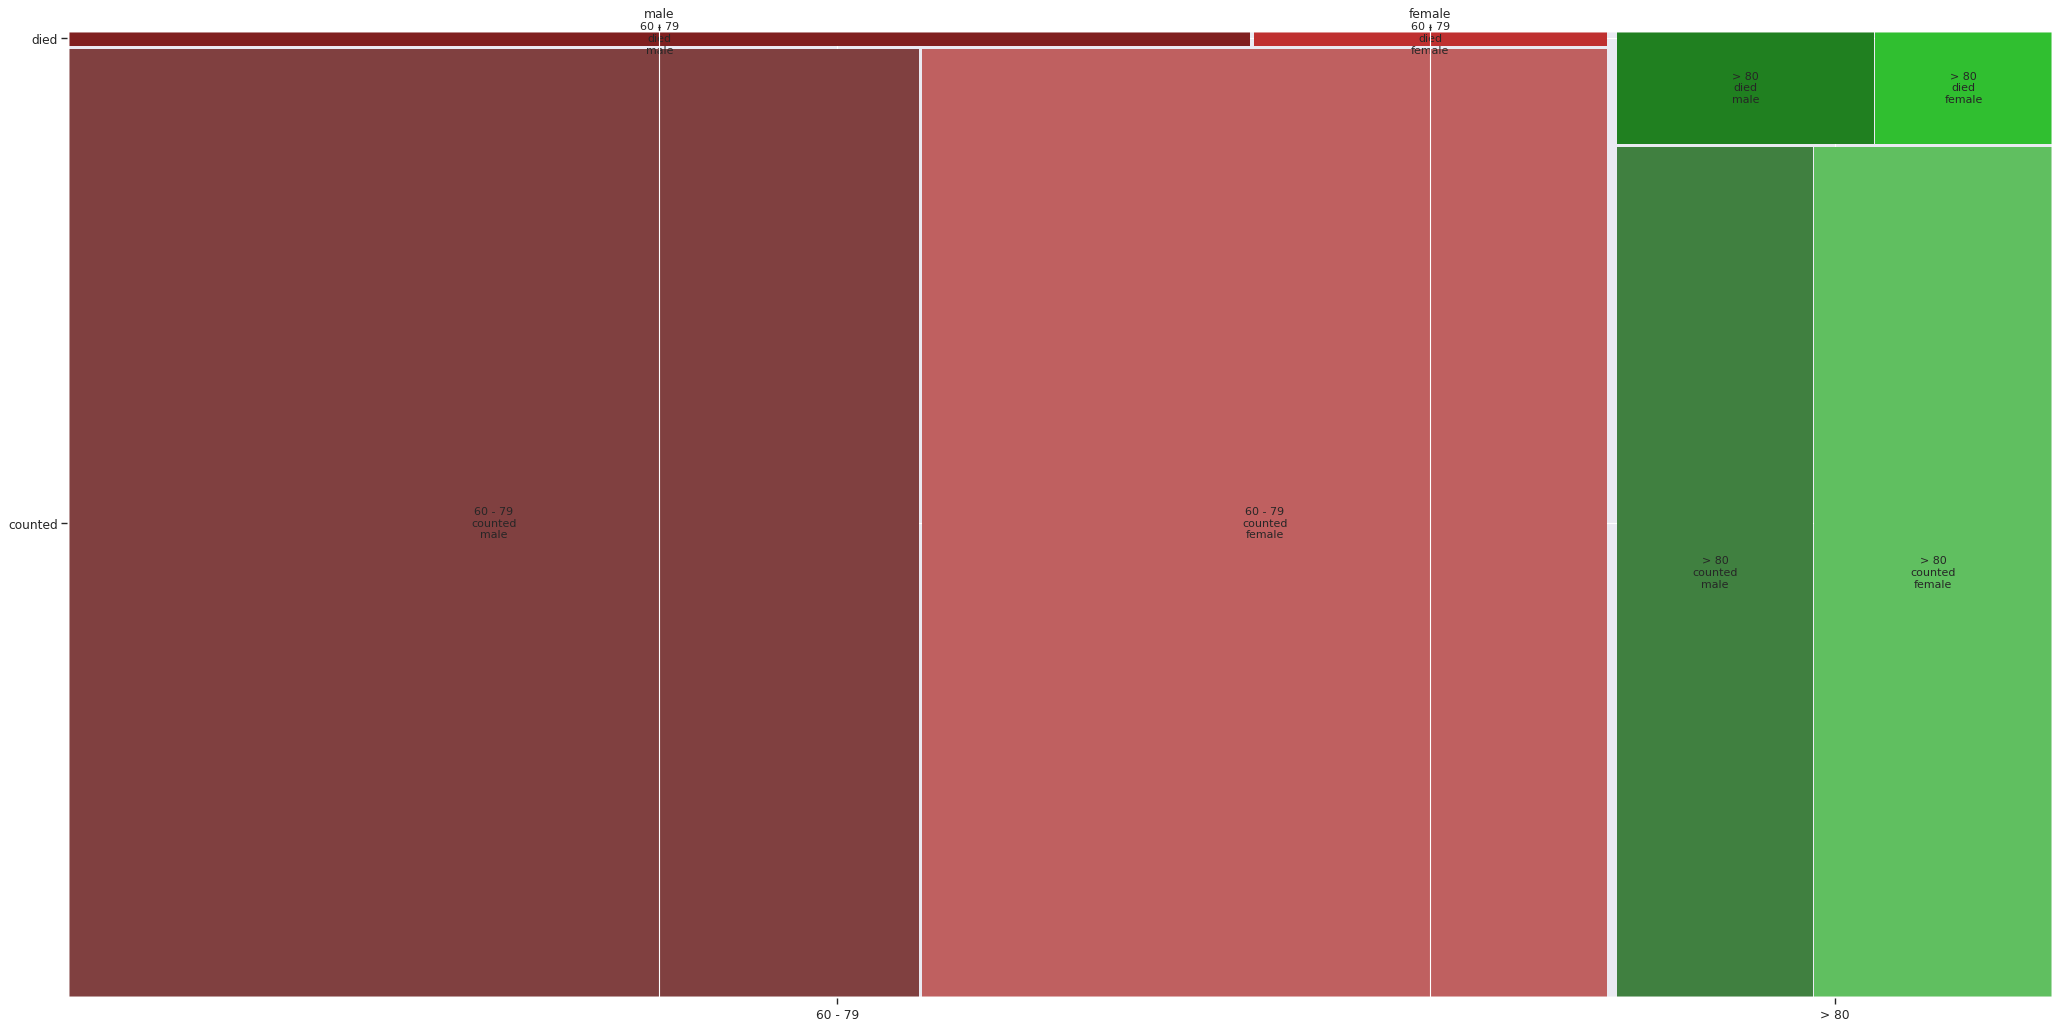

In [20]:
fig = plt.figure(figsize=(32,16), dpi=80, facecolor='w', edgecolor='k')
ax = plt.subplot(1,1,1)
statsmodels.graphics.mosaicplot.mosaic(d, ax=ax);

In [21]:
# ldf = p_xr.to_dataframe(name='p').reset_index()
# ldf = ldf[['age', 'status', 'sex', 'p']]
# ldf = ldf[ldf.status == 'died']
# ldf = ldf[['age', 'sex', 'p']]
# ldf
# pd.plotting.parallel_coordinates(ldf, 'sex')

$
\begin{align}
p(\mathrm{sex}\,|\,\mathrm{age},\mathrm{status}=\mathrm{dead})\\
\end{align}
$

In [22]:
lxr = p_xr.loc[dict(status='died')].drop_vars(['status'])
lxr = lxr / lxr.sum(['sex'])
ldf = lxr.to_dataframe(name='p').reset_index().pivot_table(index='sex', columns='age', values='p')
ldf

age,< 60,60 - 79,> 80
sex,,,
male,0.83871,0.770115,0.593085
female,0.16129,0.229885,0.406915


$
\begin{align}
p(\mathrm{status})\\
\end{align}
$

In [23]:
lxr = p_xr.copy()
lxr = lxr.sum(['sex', 'age'])
p_status = (lxr.to_dataframe(name='p') * 100.0).round(2)
p_status

,p
status,
counted,99.05
died,0.95


$
\begin{align}
p(\mathrm{status}\,|\,\mathrm{age},\mathrm{sex})\\
\end{align}
$

In [24]:
lxr = p_xr.copy()
lxr = lxr / lxr.sum(['status'])
p_status_given_sex_and_age = (lxr.to_dataframe(name='p').reset_index().pivot_table(index='status', columns=['sex','age'], values='p') * 100.0).round(2)
p_status_given_sex_and_age

sex       male                female              
age       < 60 60 - 79   > 80   < 60 60 - 79  > 80
status                                            
counted  99.89   97.87  85.13  99.98    99.2  91.0
died      0.11    2.13  14.87   0.02     0.8   9.0

In [25]:
relativ_risk = p_status_given_sex_and_age.loc[['died']] / p_status.loc['died'].values[0]
relativ_risk

sex         male                         female                    
age         < 60   60 - 79       > 80      < 60   60 - 79      > 80
status                                                             
died    0.115789  2.242105  15.652632  0.021053  0.842105  9.473684

The following is the approximate calculation that works for small probabilities and small relative risk factors:

In [26]:
p_status_is_dead_based_on_kaplan_meier = 2.6 # 2.6 percent in germany
relativ_risk * p_status_is_dead_based_on_kaplan_meier

sex         male                         female                     
age         < 60   60 - 79       > 80      < 60   60 - 79       > 80
status                                                              
died    0.301053  5.829474  40.696842  0.054737  2.189474  24.631579

The following is the "correct" calculation. The differences are only really noticeable for the "> 80" and "male":

In [27]:
values = 1.0 - np.power(1 - p_status_is_dead_based_on_kaplan_meier / 100.0, relativ_risk.iloc[0].values)
ldf = relativ_risk.copy()
ldf.iloc[0,:] = values * 100.0
ldf

sex         male                         female                     
age         < 60   60 - 79       > 80      < 60   60 - 79       > 80
status                                                              
died    0.304571  5.735542  33.790918  0.055446  2.194014  22.086777

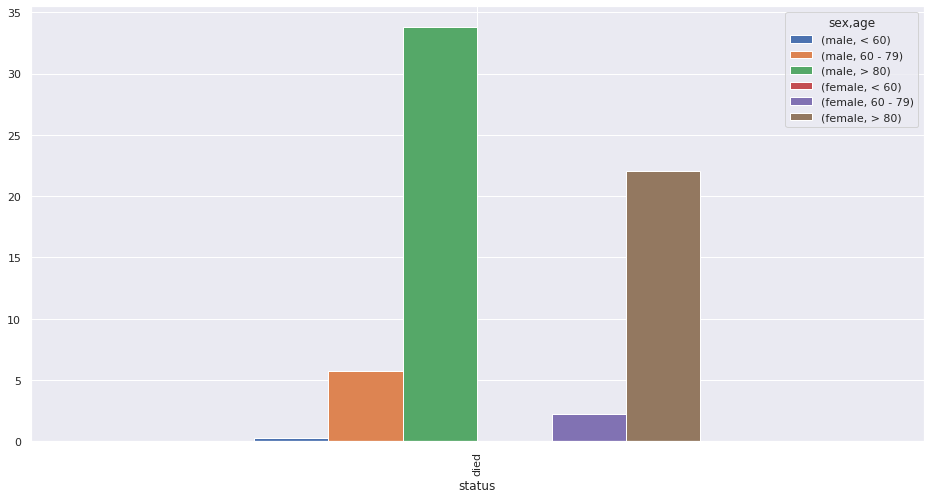

In [28]:
fig = plt.figure(figsize=(16,8))
ax = plt.subplot(1,1,1)
ldf.plot.bar(ax=ax)